STAT 453: Deep Learning (Spring 2020)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


- Runs on CPU or GPU (if available)

# 04 -- Convolutional Autoencoder and Random Forest Classifier

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 10
batch_size = 128



##########################
### MNIST DATASET
##########################


custom_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [4]:
##########################
### MODEL
##########################


class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(14-1) - 28 + 2) / 2 = 0
                                         padding=0)                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(7-1) - 14 + 2) / 2 = 0
                                         padding=0)
        
        ### DECODER
                                         
        # 7x7x8 => 14x14x8               
        # Unpool

        # 14x14x8 => 14x14x8
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)
        # 14x14x4 => 28x28x4                            
        # Unpool
        
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        
        
    def encoder(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        return x
    
    def decoder(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_4(x)
        return torch.tanh(x)
        
    def forward(self, x):
        
        ### ENCODER
        x = self.encoder(x)
        
        ### DECODER
        x = self.decoder(x)
        return x

    
torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [5]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.to(device)

        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 0.9900
Epoch: 001/010 | Batch 050/469 | Cost: 0.1433
Epoch: 001/010 | Batch 100/469 | Cost: 0.0857
Epoch: 001/010 | Batch 150/469 | Cost: 0.0628
Epoch: 001/010 | Batch 200/469 | Cost: 0.0571
Epoch: 001/010 | Batch 250/469 | Cost: 0.0528
Epoch: 001/010 | Batch 300/469 | Cost: 0.0428
Epoch: 001/010 | Batch 350/469 | Cost: 0.0430
Epoch: 001/010 | Batch 400/469 | Cost: 0.0424
Epoch: 001/010 | Batch 450/469 | Cost: 0.0362
Time elapsed: 0.19 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.0371
Epoch: 002/010 | Batch 050/469 | Cost: 0.0377
Epoch: 002/010 | Batch 100/469 | Cost: 0.0364
Epoch: 002/010 | Batch 150/469 | Cost: 0.0342
Epoch: 002/010 | Batch 200/469 | Cost: 0.0312
Epoch: 002/010 | Batch 250/469 | Cost: 0.0324
Epoch: 002/010 | Batch 300/469 | Cost: 0.0317
Epoch: 002/010 | Batch 350/469 | Cost: 0.0315
Epoch: 002/010 | Batch 400/469 | Cost: 0.0298
Epoch: 002/010 | Batch 450/469 | Cost: 0.0288
Time elapsed: 0.38 min
Epoch: 003/010 | Batch 000/469 | C

## Evaluation

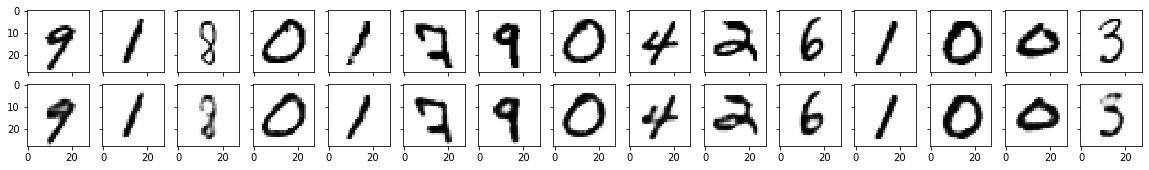

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [7]:
%watermark -iv

numpy       1.17.4
matplotlib  3.1.0
torchvision 0.5.0
torch       1.4.0



# Classifier

Image batch dimensions: torch.Size([15, 1, 28, 28])
Image label dimensions: torch.Size([15])


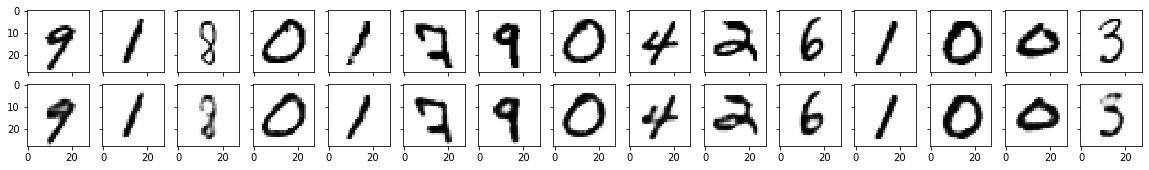

In [8]:
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=15, 
                         shuffle=True)

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

## Scikit-learn Classifier

### On Original MNIST

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=60000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=10000, 
                          shuffle=False)

In [10]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_train = np.array(images.reshape(60000, 28*28))
y_train = np.array(labels)


for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_test = np.array(images.reshape(10000, 28*28))
y_test = np.array(labels)

Image batch dimensions: torch.Size([60000, 1, 28, 28])
Image label dimensions: torch.Size([60000])
Image batch dimensions: torch.Size([10000, 1, 28, 28])
Image label dimensions: torch.Size([10000])


In [11]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train, y_train)
print(f'Train Accuracy: {rf.score(X_train, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 97.13000000000001%


### Using PCA

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7*7*8)  # same size as autoencoder latent space
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_pca, y_train)
print(f'Train Accuracy: {rf.score(X_train_pca, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test_pca, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 94.45%


### Compressed MNIST

In [14]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=1000, 
                          shuffle=False)

In [16]:
X_train_compr = np.ones((60000, 7*7*8))
y_train = np.ones(60000)

start_idx = 0

for idx, (images, labels) in enumerate(train_loader): 
    features = images.to(device)
    
    with torch.no_grad():
        encoded = model.encoder(features)
    
    X_train_compr[start_idx:start_idx+1000] = encoded.view(-1, 7*7*8).to(torch.device('cpu')).numpy()
    y_train[start_idx:start_idx+1000] = labels
    start_idx += 1000

In [17]:
X_test_compr = np.ones((10000, 7*7*8))
y_test = np.ones(10000)

start_idx = 0

for idx, (images, labels) in enumerate(test_loader): 
    features = images.to(device)
    
    with torch.no_grad():
        encoded = model.encoder(features)
    
    X_test_compr[start_idx:start_idx+1000] = encoded.view(-1, 7*7*8).to(torch.device('cpu')).numpy()
    y_test[start_idx:start_idx+1000] = labels
    start_idx += 1000

In [18]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_compr, y_train)
print(f'Train Accuracy: {rf.score(X_train_compr, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test_compr, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 96.27%


In [19]:
%watermark -iv

numpy       1.17.4
matplotlib  3.1.0
torchvision 0.5.0
torch       1.4.0

